# The Naive Bayes Classifier

* Data-driven, not model-driven
* Makes no assumptions about the data
* Named after mid-16th century English statistician and Presbyterian minister Thomas Bayes

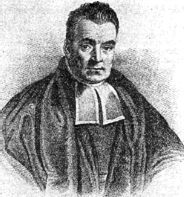

## Naïve Bayes: The Basic Idea

* For a given new record to be classified, find other records like it (i.e., same values for the predictors)
* What is the prevalent class among those records?
* Assign that class to your new record

## Usage

* Requires categorical variables
* Numerical variable must be binned and converted to categorical
* Can be used with very large data sets
* Example:  Spell check programs assign your misspelled word to an established “class” (i.e., correctly spelled word)

## Exact Bayes Classifier

* Relies on finding other records that share same predictor values as record-to-be-classified. 
* Want to find “probability of belonging to some class C, given specified values of predictors.”
* Even with large data sets, may be hard to find other records that exactly match your record, in terms of predictor values.

## Solution – Naïve Bayes

* Assume independence of predictor variables (within each class)
* Use multiplication rule of probability
* Find same probability that record belongs to class C, given predictor values, without limiting calculation to records that share all those same values

## Calculations

1. Take a record, and note its predictor values
2. Find the probabilities those predictor values occur across all records in C1
3. Multiply them together, then by proportion of records belonging to C1
4. Same for C2, C3, etc.
5. Probability of belonging to C1 is value from step (3) divide by sum of all such values C1 … Cn
6. Establish & adjust a “cutoff” probability for class of interest


## Example: Financial Fraud

Target variable:  

* Audit Outcome - finds fraud or truthful (no fraud)

Predictors:  
* Prior pending legal charges (y/n)
* Size of firm (small/large)

Data:

| Charges | Size | Outcome  |
| :-------: |:----:|:------:|
| y | small | truthful |
| n | small | truthful |
| n | large | truthful |
| n | large | truthful |
| n | small | truthful |
| n | small | truthful |
| y | small | fraud |
| y | large | fraud |
| n | large | fraud |
| y | large | fraud |

## Exact Bayes Calculations

**Goal** Classify (as “fraudulent” or as “truthful”) a **small** firm with charges filed

**Note** There are 2 firms like that, one fraudulent and the other truthful

**Conditional Probability** 

P(fraud | charges=y, size=small) = ½ = 0.50

**Calculations** 

Compute 2 quantities:
Proportion of “charges = y” among frauds times proportion of “small” among frauds times proportion frauds = 3/4 * 1/4 * 4/10 = 0.075

Proportion of “charges = y” among frauds times proportion “small” among truthfuls times proportion truthfuls = 1/6 * 4/6 * 6/10 = 0.067

P(fraud | charges, small) = 0.075/(0.075 + 0.067) = 0.53

**Notes** 

* The probability estimate does not differ greatly from exact
* All records are used in calculations, not just those matching predictor values
* This makes calculations practical in most circumstances
* Relies on assumption of independence between predictor variables within each class


## Flight Delays

### **Predictors**

**Day of Week:** Coded as 1 = Monday, 2 = Tuesday, ..., 7 = Sunday

**Scheduled Departure Time:**  Broken down into 18 intervals between 6:00 AM and 10:00 PM

**Origin:** Airport codes: DCA (Reagan National), IAD (Dulles), (Baltimore–Washington Int’l)

**Destination:** Airport codes: JFK (Kennedy), LGA (LaGuardia), EWR (Newark)

**Carrier:** Airline codes: CO (Continental), DH (Atlantic Coast), DL (Delta),  MQ (American Eagle), OH (Comair),  RU (Continental Express), UA (United), US (USAirways)

### **Outcome** Delay (0,1)

In [1]:
# import required packages
%matplotlib inline

import matplotlib.pylab as plt
import pandas as pd
from dmba import classificationSummary, gainsChart
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [2]:
delays_df = pd.read_csv('datasets/FlightDelays.csv')
print(delays_df.head())

   CRS_DEP_TIME CARRIER  DEP_TIME DEST  DISTANCE     FL_DATE  FL_NUM ORIGIN  \
0          1455      OH      1455  JFK       184  01/01/2004    5935    BWI   
1          1640      DH      1640  JFK       213  01/01/2004    6155    DCA   
2          1245      DH      1245  LGA       229  01/01/2004    7208    IAD   
3          1715      DH      1709  LGA       229  01/01/2004    7215    IAD   
4          1039      DH      1035  LGA       229  01/01/2004    7792    IAD   

   Weather  DAY_WEEK  DAY_OF_MONTH TAIL_NUM Flight Status  
0        0         4             1   N940CA        ontime  
1        0         4             1   N405FJ        ontime  
2        0         4             1   N695BR        ontime  
3        0         4             1   N662BR        ontime  
4        0         4             1   N698BR        ontime  


In [3]:
# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER']
outcome = 'Flight Status'

X = pd.get_dummies(delays_df[predictors])
y = (delays_df[outcome] == 'delayed').astype(int)
classes = ['ontime', 'delayed']

# split into training and validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.40, random_state=1)

# run naive Bayes
delays_nb = MultinomialNB(alpha=0.01)
delays_nb.fit(X_train, y_train)

# predict probabilities
predProb_train = delays_nb.predict_proba(X_train)
predProb_valid = delays_nb.predict_proba(X_valid)

# predict class membership
y_valid_pred = delays_nb.predict(X_valid)
y_train_pred = delays_nb.predict(X_train)

First construct a frequency table and then convert it to the probability table

In [4]:
# split the original data frame into a train and test using the same random_state
train_df, valid_df = train_test_split(delays_df, test_size=0.4, random_state=1)

pd.set_option('precision', 4)

# probability of flight status
print(train_df['Flight Status'].value_counts() / len(train_df))
print()

for predictor in predictors:
    # construct the frequency table
    df = train_df[['Flight Status', predictor]]
    freqTable = df.pivot_table(index='Flight Status', columns=predictor, aggfunc=len)

    # divide each row by the sum of the row to get conditional probabilities
    propTable = freqTable.apply(lambda x: x / sum(x), axis=1)
    print(propTable)
    print()
    
pd.reset_option('precision')

ontime     0.8023
delayed    0.1977
Name: Flight Status, dtype: float64

DAY_WEEK            1       2       3       4       5      6       7
Flight Status                                                       
delayed        0.1916  0.1494  0.1149  0.1264  0.1877  0.069  0.1609
ontime         0.1246  0.1416  0.1445  0.1794  0.1690  0.136  0.1048

CRS_DEP_TIME       6       7       8       9       10      11      12      13  \
Flight Status                                                                   
delayed        0.0345  0.0536  0.0651  0.0192  0.0307  0.0115  0.0498  0.0460   
ontime         0.0623  0.0633  0.0850  0.0567  0.0519  0.0340  0.0661  0.0746   

CRS_DEP_TIME       14      15      16      17      18      19      20      21  
Flight Status                                                                  
delayed        0.0383  0.2031  0.0728  0.1533  0.0192  0.0996  0.0153  0.0881  
ontime         0.0576  0.1171  0.0774  0.1001  0.0349  0.0397  0.0264  0.0529  

ORIG

In [8]:
# P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_delayed = 0.0958 * 0.1609 * 0.0307 * 0.4215 * 0.5211 * 0.1977

# P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA)
P_hat_ontime = 0.2040 * 0.1048 * 0.0519 * 0.5779 * 0.6478 * 0.8023

print('P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA')
print('P_hat_delayed ~ ', P_hat_delayed)
print()
print('P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA')
print('P_hat_ontime ~ ', P_hat_ontime)
print()
print('P(delayed|...) = ', P_hat_delayed / (P_hat_delayed + P_hat_ontime))
print('P(ontime|...) = ', P_hat_ontime / (P_hat_delayed + P_hat_ontime))

P(delayed | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA
P_hat_delayed ~  2.0548742506526157e-05

P(ontime | Carrier = DL, Day_Week = 7, Dep_Time = 10, Dest = LGA, Origin = DCA
P_hat_ontime ~  0.00033326464123921066

P(delayed|...) =  0.05807791183301656
P(ontime|...) =  0.9419220881669834


In [6]:
# Subset a specific set
df = pd.concat([pd.DataFrame({'actual': y_valid, 'predicted': y_valid_pred}),
                pd.DataFrame(predProb_valid, index=y_valid.index)], axis=1)
mask = ((X_valid.CARRIER_DL == 1) & (X_valid.DAY_WEEK_7 == 1) & (X_valid.CRS_DEP_TIME_10 == 1) & 
        (X_valid.DEST_LGA == 1) & (X_valid.ORIGIN_DCA == 1))
print(df[mask])

      actual  predicted         0         1
1225       0          0  0.942011  0.057989


In [7]:
print('Training\n')
classificationSummary(y_train, y_train_pred, class_names=classes) 
print('\n\nTesting\n')
classificationSummary(y_valid, y_valid_pred, class_names=classes)

Training

Confusion Matrix (Accuracy 0.7955)

        Prediction
 Actual  ontime delayed
 ontime     998      61
delayed     209      52


Testing

Confusion Matrix (Accuracy 0.7821)

        Prediction
 Actual  ontime delayed
 ontime     663      51
delayed     141      26
